# European Develompent Indicators - Iceland

## Research Questions

1. How has Iceland's GDP growth correlated with inflation rates over the past 20 years?

2. What is the relationship between educational attainment and unemployment in Iceland?

3. What is the gender wage gap trend in Iceland, and how does it compare with female employment rates?

## Datasets

* [namq_10_gdp](https://doi.org/10.2908/NAMQ_10_GDP) - Eurostat: Quarterly GDP

* [nama_10_co3_p3](https://doi.org/10.2908/NAMA_10_CO3_P3) - Eurostat: Annual household disposable income

* [tec00001](https://doi.org/10.2908/TEC00001) - Eurostat: Annual GDP at market prices

* [prc_hicp_midx](https://doi.org/10.2908/PRC_HICP_MIDX) - Eurostat: Monthly Harmonized CPI

* [prc_hicp_manr](https://doi.org/10.2908/PRC_HICP_MANR) - Eurostat: Monthly CPI inflation rate

* [prc_hicp_inw](https://doi.org/10.2908/PRC_HICP_INW) - Eurostat: Annual CPI inflation rate by income group

* [lfsa_urgaed](https://doi.org/10.2908/LFSA_URGAED) - Eurostat: Annual unemployment rate by education level

* [lfsa_egaed](https://doi.org/10.2908/LFSA_EGAED) - Eurostat: Annual employment rate by education level

* [lfsa_egised](https://doi.org/10.2908/LFSA_EGISED) - Eurostat: Annual employed persons by occupation and educational attainment level

* [lfsa_egan](https://doi.org/10.2908/LFSA_EGAN) - Eurostat: Annual employment

* [lfsi_emp_q](https://doi.org/10.2908/LFSI_EMP_Q) - Eurostat: Quarterly employment and activity by sex and age

* [lfsi_long_q](https://doi.org/10.2908/LFSI_LONG_Q) - Eurostat: Quarterly labour market transitions

* [lfsq_ergan](https://doi.org/10.2908/LFSQ_ERGAN) - Eurostat: Quarterly employment rates by citizenship

* [une_rt_m](https://doi.org/10.2908/UNE_RT_M) - Eurostat: Monthly total unemployment rate

* [edat_lfse_03](https://doi.org/10.2908/EDAT_LFSE_03) - Eurostat: Annual population by educational attainment level

* [earn_nt_net](https://doi.org/10.2908/EARN_NT_NET) - Eurostat: Annual net earnings

* [earn_gr_gpgr2](https://doi.org/10.2908/EARN_GR_GPGR2) - Eurostat: Annual gender pay gap in unadjusted form


# Definitions

#### `s_adj` — Seasonal Adjustment

| Code  | Meaning                            |
| ----- | ---------------------------------- |
| `SCA` | Seasonal & calendar adjusted       |
| `NSA` | Not seasonally adjusted            |


#### `na_item` — National Accounts Item

| Code   | Meaning                                                           |
| ------ | ----------------------------------------------------------------- |
| `B1GQ` | Gross Domestic Product (GDP), volume, chain-linked, market prices |


#### `unit` — Unit of Measure
| Code         | Meaning                              |
| ------------ | ------------------------------------ |
| `CLV10_MEUR` | Chain linked volumes, base year 2010 |


#### `coicop` — Consumption Purpose Categories

| Code   | Meaning        |
| ------ | -------------- |
| `CP00` | All-items HICP |



## Imports

In [72]:
import os
from typing import Literal

import eurostat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [73]:
COUNTRY_NAME = "Iceland"
COUNTRY_CODE = "IS"

ORIGINAL_DATA_DIR = "original_data"
DATAFRAME_INFO: dict[pd.DataFrame, dict[str, str]] = {}

In [74]:
def get_dataframe(eurostat_code: str, country_code: str = COUNTRY_CODE) -> pd.DataFrame:
    file_path = os.path.join(ORIGINAL_DATA_DIR, f"{eurostat_code}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

    else:
        df = eurostat.get_data_df(eurostat_code)
        os.makedirs(ORIGINAL_DATA_DIR, exist_ok=True)
        df.to_csv(file_path, index=False)

    df = df[df["geo\\TIME_PERIOD"] == country_code]
    df.rename(columns={"geo\\TIME_PERIOD": "geo"}, inplace=True)

    return df


In [75]:
def fix_dates(src_df: pd.DataFrame) -> pd.DataFrame:
    df = src_df.copy()

    column_names = df.columns.tolist()
    time_period_index = column_names.index("geo")
    data_columns = column_names[time_period_index + 1 :]

    if df["freq"].iloc[0] == "M":
        df.rename(columns={col: f"{col[:4]}-{col[5:7]}-01" for col in data_columns}, inplace=True)
    elif df["freq"].iloc[0] == "Q":
        df.rename(columns={col: f"{col[:4]}-{(int(col[6]) - 1) * 3 + 1:02d}-01" for col in data_columns}, inplace=True)
    elif df["freq"].iloc[0] == "A":
        df.rename(columns={col: f"{col}-01-01" for col in data_columns}, inplace=True)

    return df


In [76]:
def remove_empty_columns(src_df: pd.DataFrame) -> pd.DataFrame:
    df = src_df.copy()
    df.dropna(axis=1, how="all", inplace=True)

    return df


In [77]:
def melt_dataframe(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    column_names = src_df.columns.tolist()
    time_period_index = column_names.index("geo")
    data_columns = column_names[time_period_index + 1 :]
    id_cols = column_names[: time_period_index + 1]

    df_melted = src_df.melt(id_vars=id_cols, value_vars=data_columns, var_name="time", value_name="value")
    df_melted = df_melted.drop(columns=["geo"])
    df_melted = df_melted.dropna(subset=["value"])
    df_melted["value"] = pd.to_numeric(df_melted["value"], errors="coerce")

    return df_melted


In [78]:
def drop_columns(src_df: pd.DataFrame, columns_to_drop: list[str]) -> pd.DataFrame:
    df = src_df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    return df


In [79]:
def filter_dataframe(src_df: pd.DataFrame, filter: dict[str, list[str]]) -> pd.DataFrame:
    df = src_df.copy()

    for column, values in filter.items():
        df = df[df[column].isin(values)]

    return df


In [80]:
def get_unique_values(src_df: pd.DataFrame) -> dict[str, list[str]]:
    df = src_df.copy()
    df = df.drop(columns=["time", "value"]).drop_duplicates()

    unique_values = {col: df[col].unique().tolist() for col in df.columns}

    return unique_values


In [81]:
def make_histogram(
    src_df: pd.DataFrame,
    bins: Literal["auto", "sturges", "fd", "doane", "scott", "rice", "sqrt"] = "auto",
) -> plt:
    df = src_df.copy()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="value", bins=bins, kde=True)
    plt.title("Histogram of Values")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)

    return plt


In [82]:
def make_line_plot(
    src_df: pd.DataFrame,
) -> plt:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="time", y="value")
    plt.title("Line Plot of Values Over Time")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    return plt


In [83]:
def make_scatter_plot(
    src_df: pd.DataFrame,
) -> plt:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x="time", y="value")
    plt.title("Scatter Plot of Values Over Time")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    return plt


In [84]:
def make_box_plot(
    src_df: pd.DataFrame,
) -> plt:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=df["value"])
    plt.title("Box Plot of Values by Year")

    return plt

In [85]:
def make_correlation_heatmap(
    dataframes: list[pd.DataFrame],
) -> plt:
    combined_df = pd.DataFrame()

    for df in dataframes:
        temp_df = df.copy()
        temp_df["time"] = pd.to_datetime(temp_df["time"])
        temp_df.set_index("time", inplace=True)
        temp_df = temp_df.rename(columns={"value": df.name})
        combined_df = pd.concat([combined_df, temp_df[df.name]], axis=1)

    correlation_matrix = combined_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")

    return plt



# How has Iceland's GDP growth correlated with inflation rates over the past 20 years?

## Datasets:

* [namq_10_gdp](https://doi.org/10.2908/NAMQ_10_GDP) - Eurostat: Quarterly GDP

* [nama_10_co3_p3](https://doi.org/10.2908/NAMA_10_CO3_P3) - Eurostat: Annual household disposable income

* [tec00001](https://doi.org/10.2908/TEC00001) - Eurostat: Annual GDP at market prices

* [prc_hicp_midx](https://doi.org/10.2908/PRC_HICP_MIDX) - Eurostat: Monthly Harmonized CPI

* [prc_hicp_manr](https://doi.org/10.2908/PRC_HICP_MANR) - Eurostat: Monthly CPI inflation rate

* [prc_hicp_inw](https://doi.org/10.2908/PRC_HICP_INW) - Eurostat: Annual CPI inflation rate by income group


### namq_10_gdp

,unit,s_adj,na_item,time,value
95,CLV10_MEUR,SCA,B1GQ,1995-01-01,1578.1
1290,CLV10_MEUR,SCA,B1GQ,1995-04-01,1610.4
2485,CLV10_MEUR,SCA,B1GQ,1995-07-01,1625.4
3680,CLV10_MEUR,SCA,B1GQ,1995-10-01,1613.9
4875,CLV10_MEUR,SCA,B1GQ,1996-01-01,1671.2


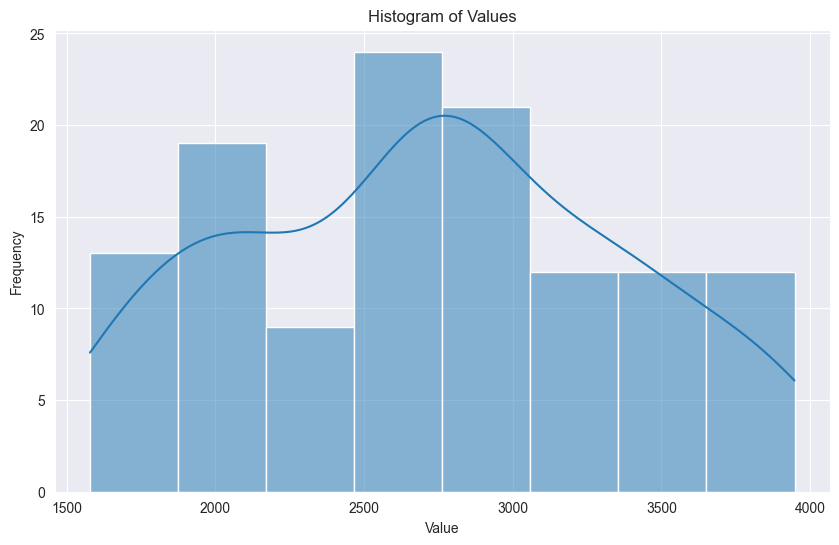

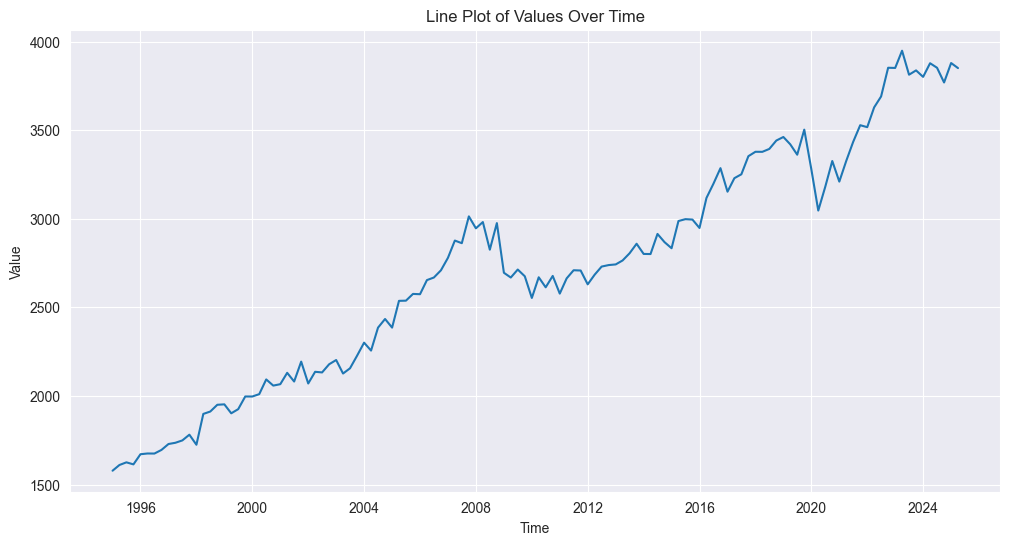

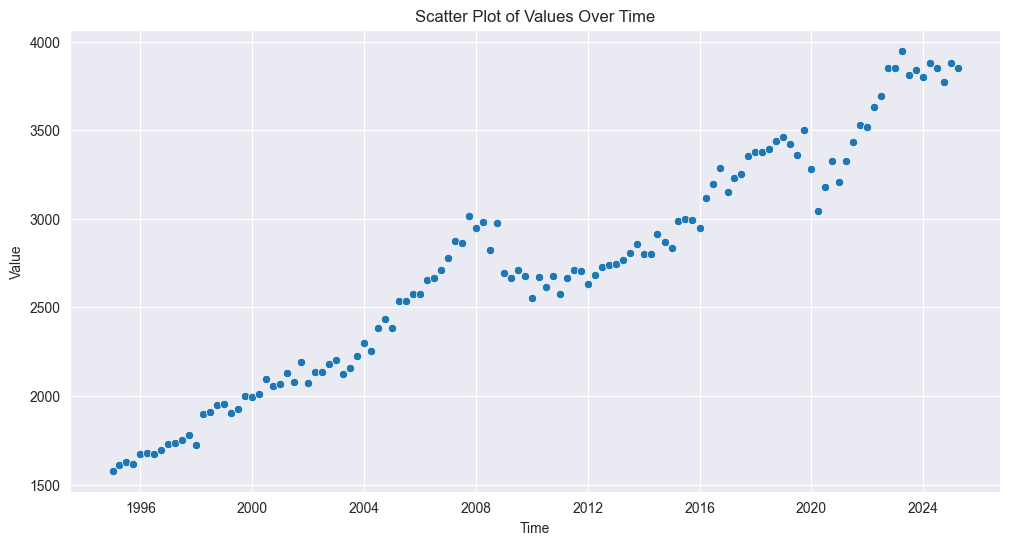

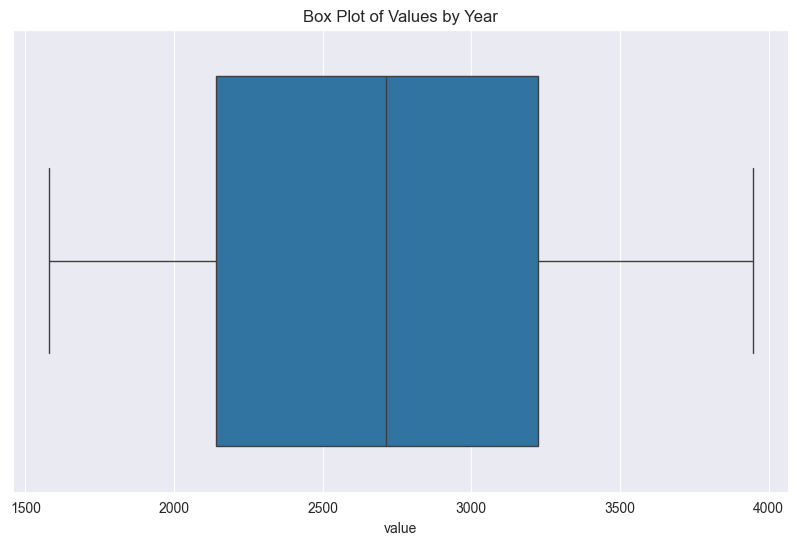

In [86]:
namq_10_gdp = get_dataframe("namq_10_gdp")
namq_10_gdp = fix_dates(namq_10_gdp)
namq_10_gdp = remove_empty_columns(namq_10_gdp)
namq_10_gdp = melt_dataframe(namq_10_gdp)
namq_10_gdp = drop_columns(namq_10_gdp, ["freq"])
namq_10_gdp = filter_dataframe(namq_10_gdp, {"unit": ["CLV10_MEUR"], "na_item": ["B1GQ"], "s_adj": ["SCA"]})
namq_10_gdp.name = "namq_10_gdp"


display(namq_10_gdp.head())
make_histogram(namq_10_gdp).show()
make_line_plot(namq_10_gdp).show()
make_scatter_plot(namq_10_gdp).show()
make_box_plot(namq_10_gdp).show()


### nama_10_co3_p3

,unit,coicop,time,value
182,CLV10_MEUR,TOTAL,1995-01-01,3208.9
1890,CLV10_MEUR,TOTAL,1996-01-01,3369.0
3598,CLV10_MEUR,TOTAL,1997-01-01,3565.5
5306,CLV10_MEUR,TOTAL,1998-01-01,3951.3
7014,CLV10_MEUR,TOTAL,1999-01-01,4240.4


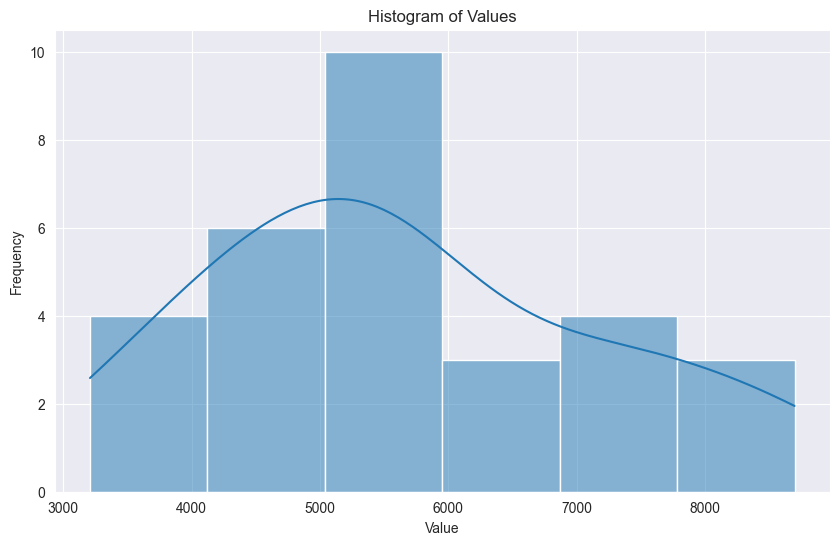

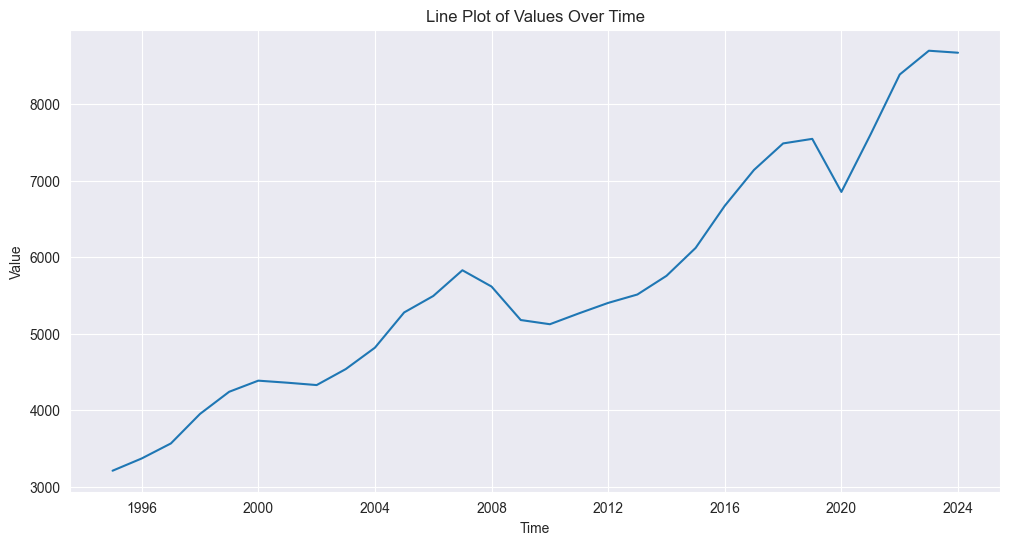

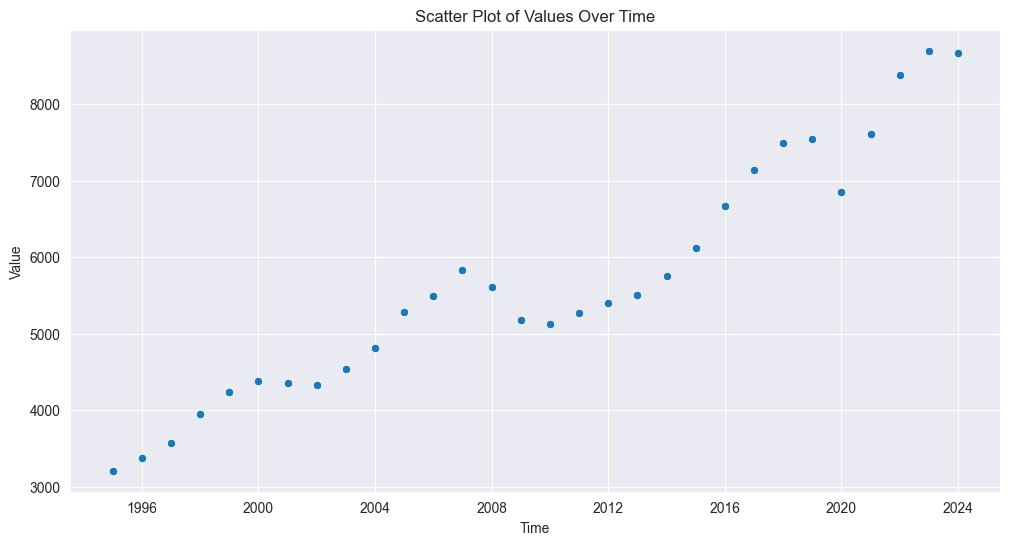

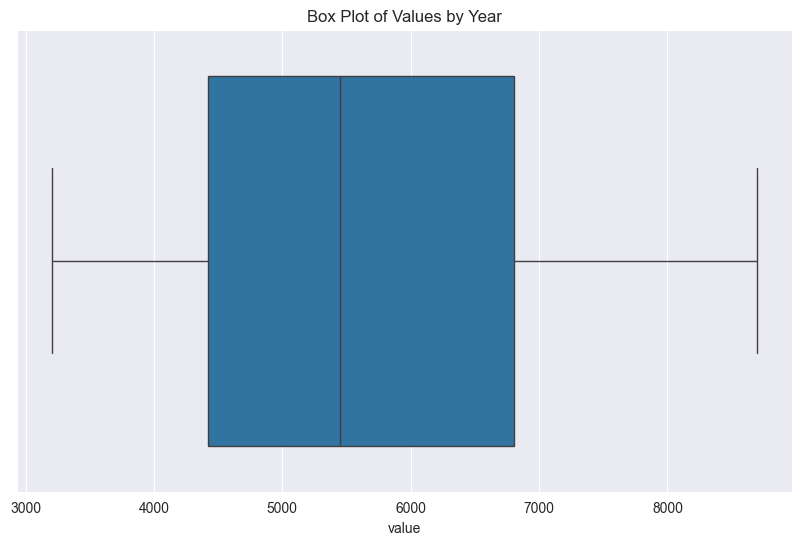

In [88]:
nama_10_co3_p3 = get_dataframe("nama_10_co3_p3")
nama_10_co3_p3 = fix_dates(nama_10_co3_p3)
nama_10_co3_p3 = remove_empty_columns(nama_10_co3_p3)
nama_10_co3_p3 = melt_dataframe(nama_10_co3_p3)
nama_10_co3_p3 = drop_columns(nama_10_co3_p3, ["freq"])
nama_10_co3_p3 = filter_dataframe(nama_10_co3_p3, {"unit": ["CLV10_MEUR"], "coicop": ["TOTAL"]})
nama_10_co3_p3.name = "nama_10_co3_p3"

display(nama_10_co3_p3.head())
make_histogram(nama_10_co3_p3).show()
make_line_plot(nama_10_co3_p3).show()
make_scatter_plot(nama_10_co3_p3).show()
make_box_plot(nama_10_co3_p3).show()


### tec00001

,na_item,unit,time,value
1,B1GQ,CP_MEUR,2013-01-01,12222.7
3,B1GQ,CP_MEUR,2014-01-01,13611.7
5,B1GQ,CP_MEUR,2015-01-01,15960.5
7,B1GQ,CP_MEUR,2016-01-01,19067.0
9,B1GQ,CP_MEUR,2017-01-01,22211.8


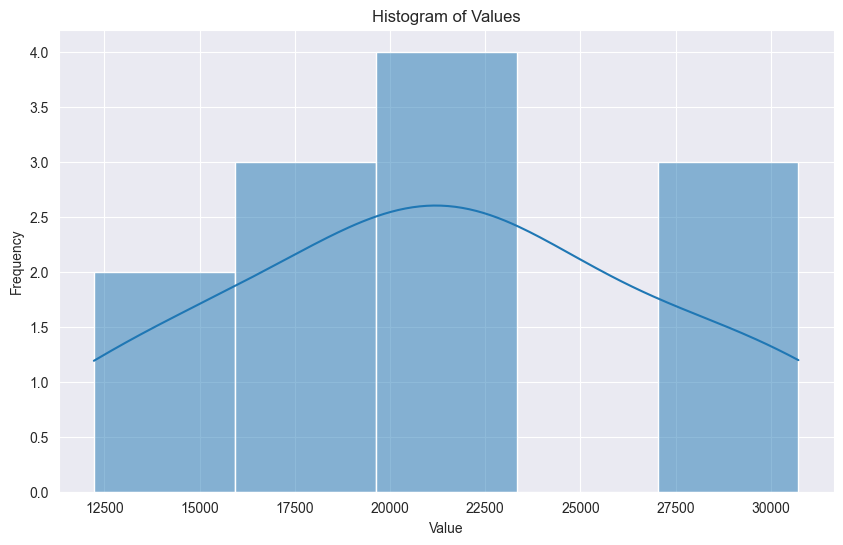

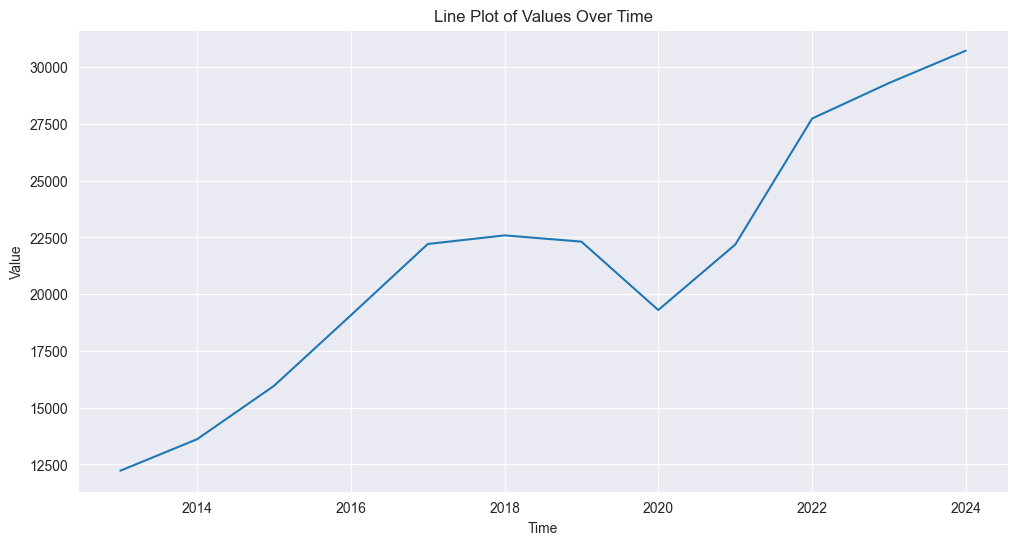

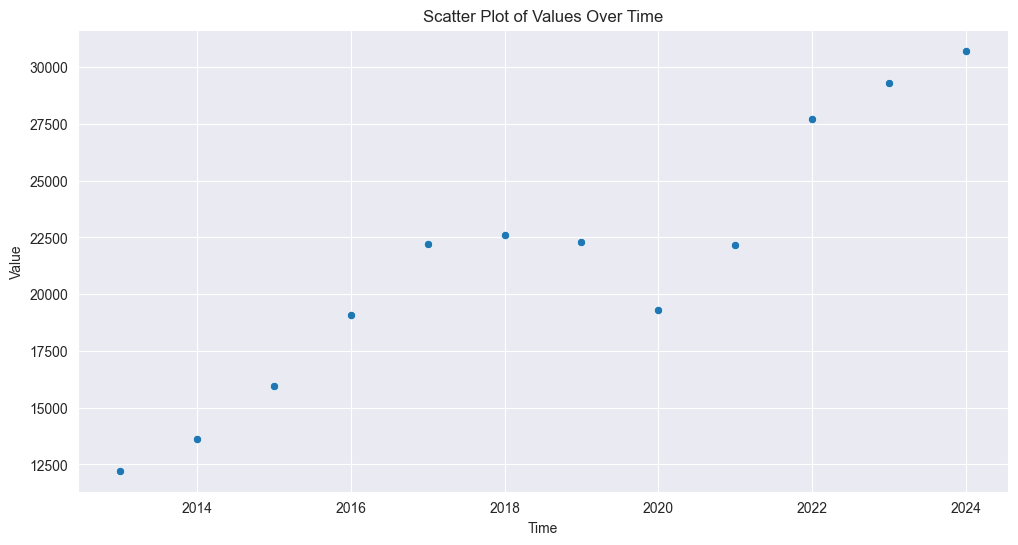

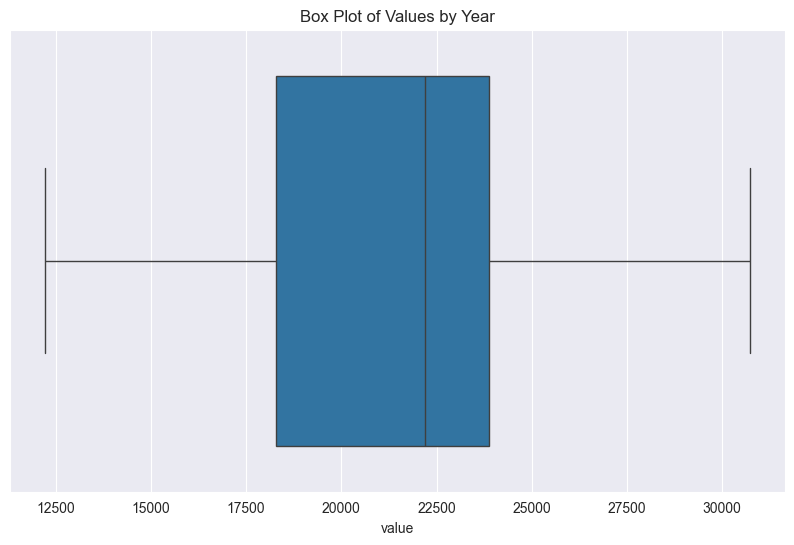

In [89]:
tec00001 = get_dataframe("tec00001")
tec00001 = fix_dates(tec00001)
tec00001 = remove_empty_columns(tec00001)
tec00001 = melt_dataframe(tec00001)
tec00001 = drop_columns(tec00001, ["freq"])
tec00001 = filter_dataframe(tec00001, {"unit": ["CP_MEUR"], "na_item": ["B1GQ"]})
tec00001.name = "tec00001"

display(tec00001.head())
make_histogram(tec00001).show()
make_line_plot(tec00001).show()
make_scatter_plot(tec00001).show()
make_box_plot(tec00001).show()


### prc_hicp_midx

,unit,coicop,time,value
156,I15,CP00,1996-01-01,42.75
813,I15,CP00,1996-02-01,42.83
1470,I15,CP00,1996-03-01,42.92
2127,I15,CP00,1996-04-01,43.09
2784,I15,CP00,1996-05-01,43.27


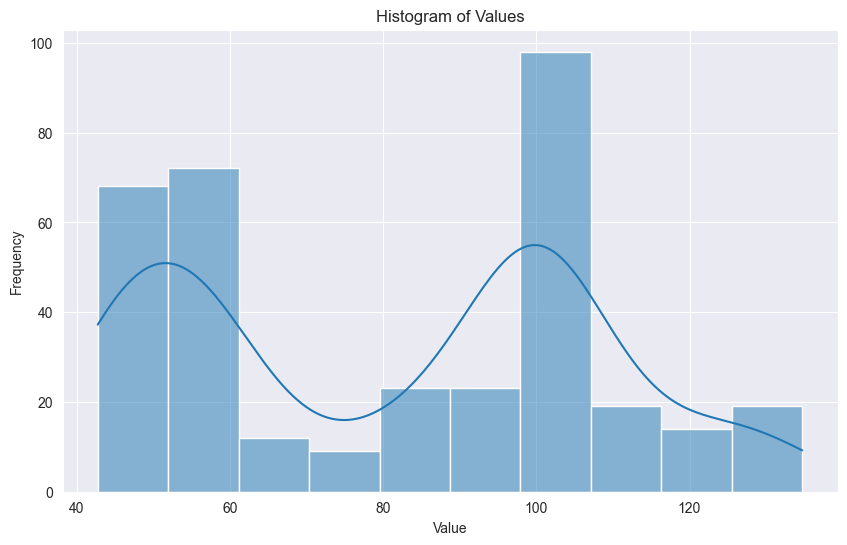

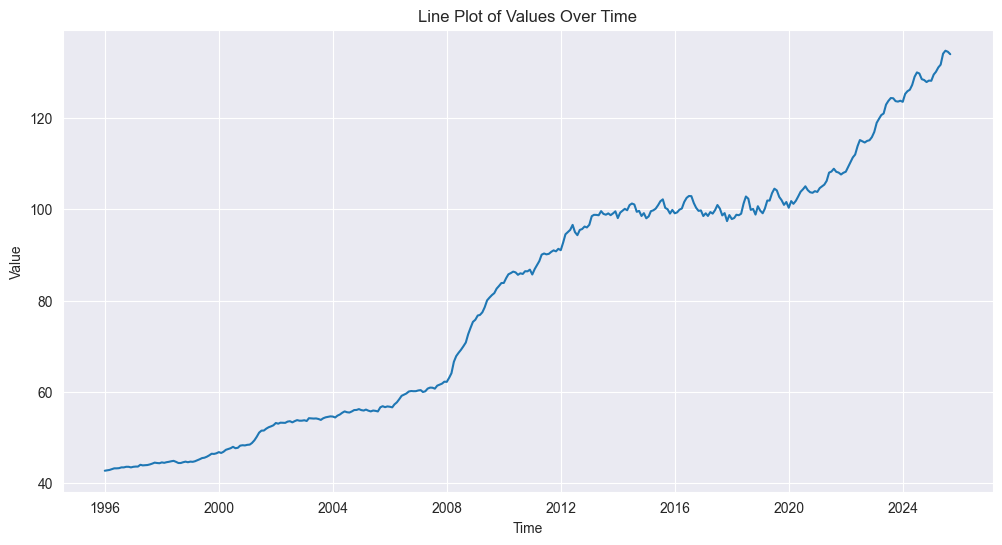

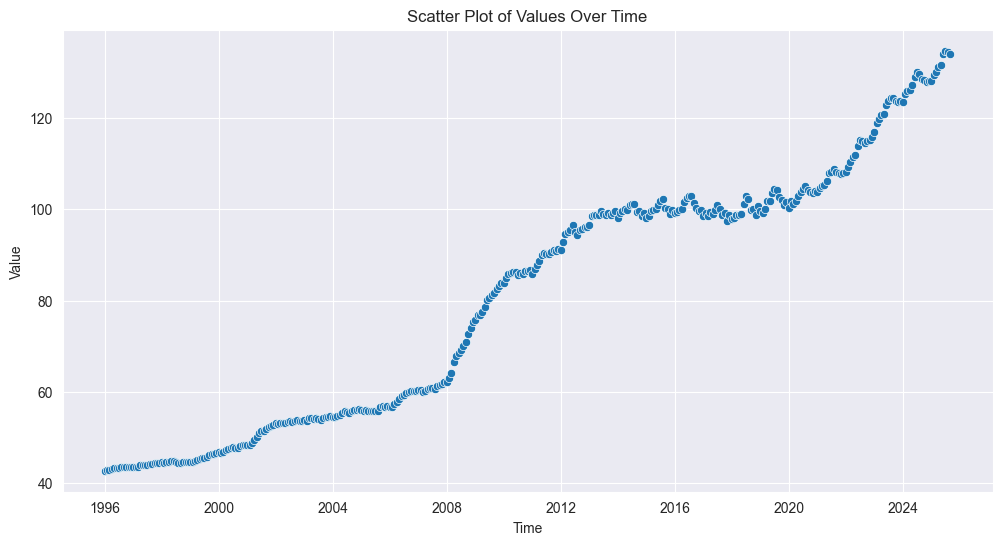

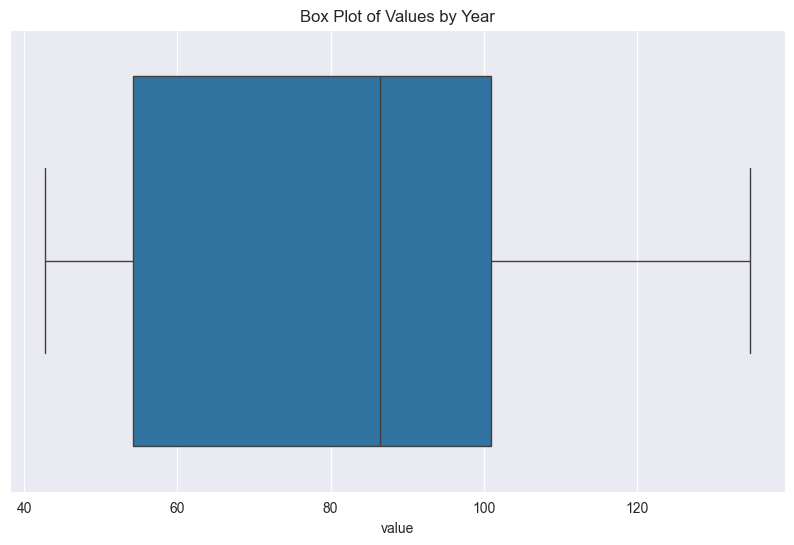

In [90]:
prc_hicp_midx = get_dataframe("prc_hicp_midx")
prc_hicp_midx = fix_dates(prc_hicp_midx)
prc_hicp_midx = remove_empty_columns(prc_hicp_midx)
prc_hicp_midx = melt_dataframe(prc_hicp_midx)
prc_hicp_midx = drop_columns(prc_hicp_midx, ["freq"])
prc_hicp_midx = filter_dataframe(prc_hicp_midx, {"unit": ["I15"], "coicop": ["CP00"]})
prc_hicp_midx.name = "prc_hicp_midx"

display(prc_hicp_midx.head())
make_histogram(prc_hicp_midx).show()
make_line_plot(prc_hicp_midx).show()
make_scatter_plot(prc_hicp_midx).show()
make_box_plot(prc_hicp_midx).show()


### prc_hicp_manr

,unit,coicop,time,value
0,RCH_A,CP00,1997-01-01,2.0
364,RCH_A,CP00,1997-02-01,1.9
728,RCH_A,CP00,1997-03-01,1.7
1092,RCH_A,CP00,1997-04-01,2.2
1456,RCH_A,CP00,1997-05-01,1.5


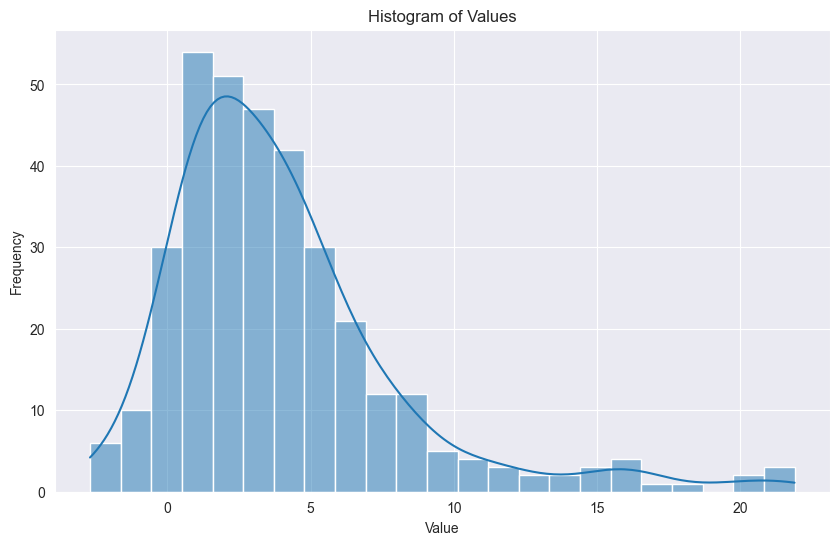

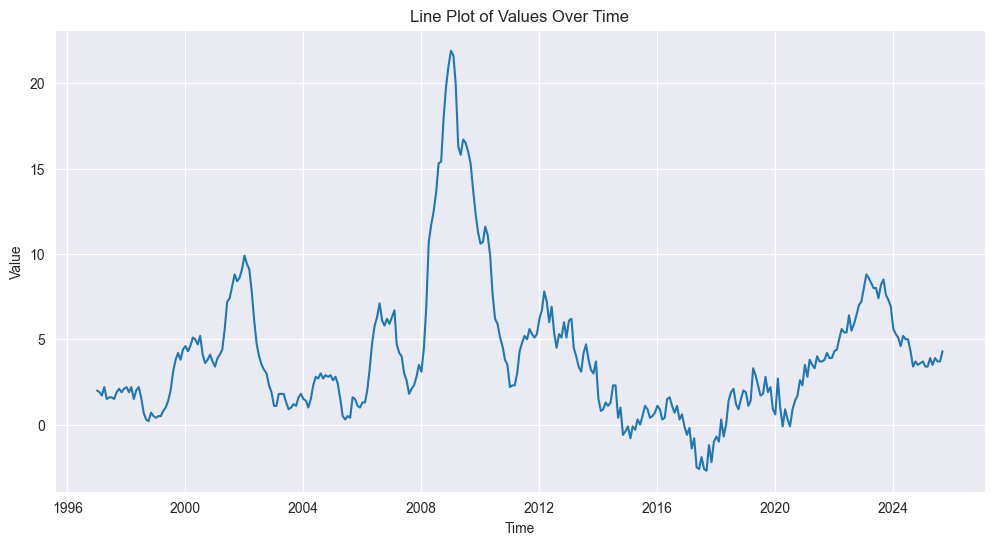

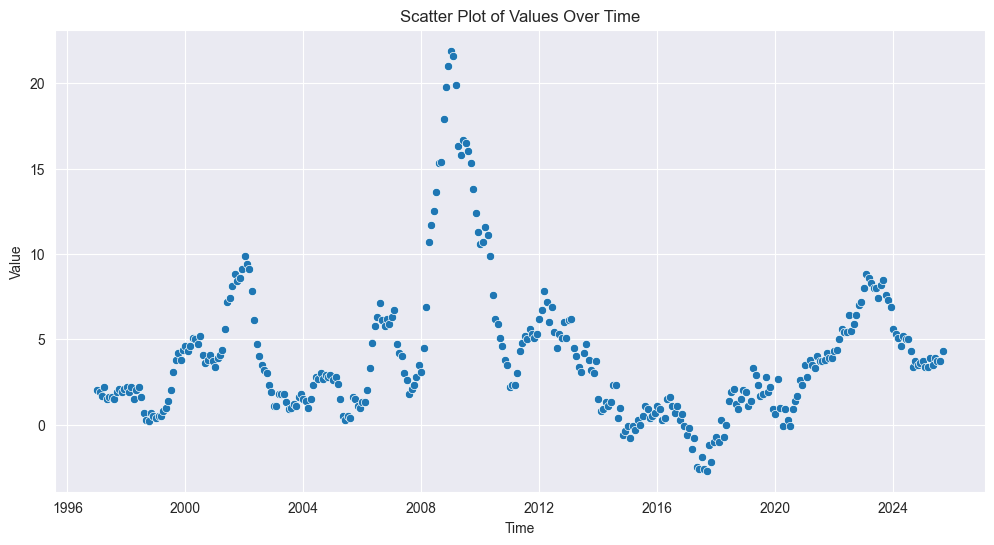

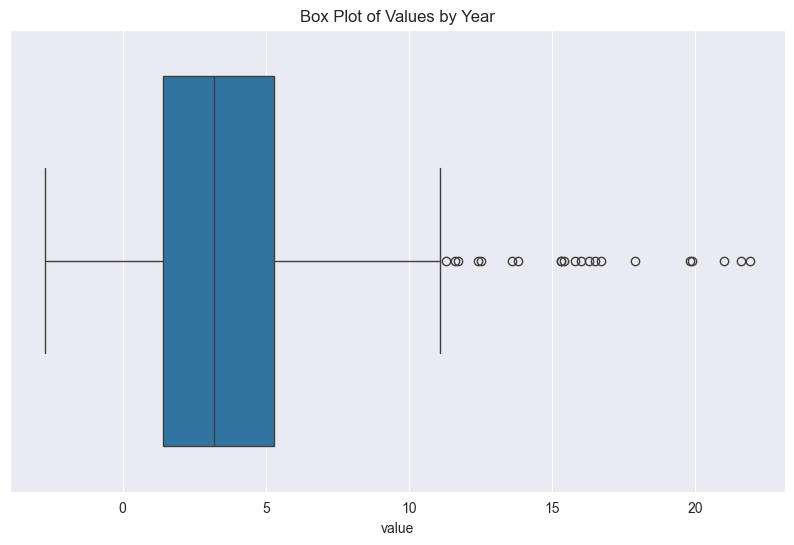

In [91]:
prc_hicp_manr = get_dataframe("prc_hicp_manr")
prc_hicp_manr = fix_dates(prc_hicp_manr)
prc_hicp_manr = remove_empty_columns(prc_hicp_manr)
prc_hicp_manr = melt_dataframe(prc_hicp_manr)
prc_hicp_manr = drop_columns(prc_hicp_manr, ["freq"])
prc_hicp_manr = filter_dataframe(prc_hicp_manr, {"unit": ["RCH_A"], "coicop": ["CP00"]})
prc_hicp_manr.name = "prc_hicp_manr"

display(prc_hicp_manr.head())
make_histogram(prc_hicp_manr).show()
make_line_plot(prc_hicp_manr).show()
make_scatter_plot(prc_hicp_manr).show()
make_box_plot(prc_hicp_manr).show()


### prc_hicp_inw

,coicop,time,value
3,CP01,1996-01-01,207.70
463,CP01,1997-01-01,206.60
923,CP01,1998-01-01,211.34
1383,CP01,1999-01-01,210.25
1843,CP01,2000-01-01,192.74


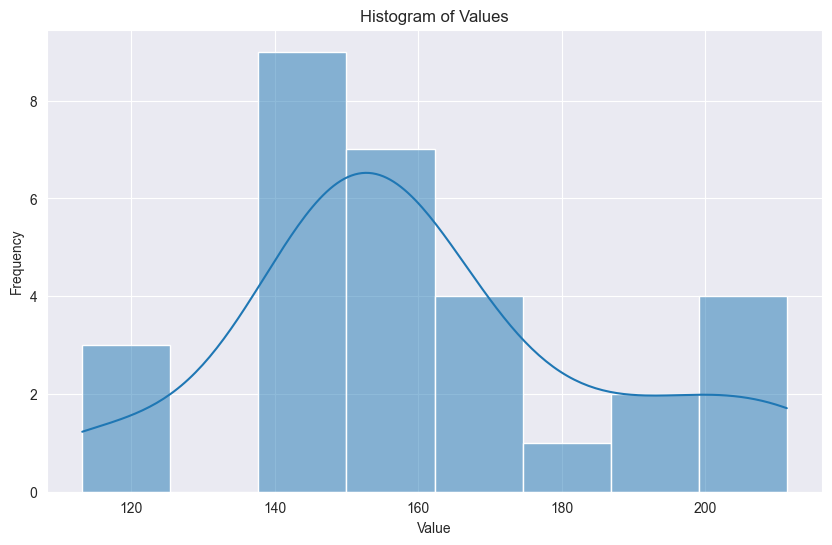

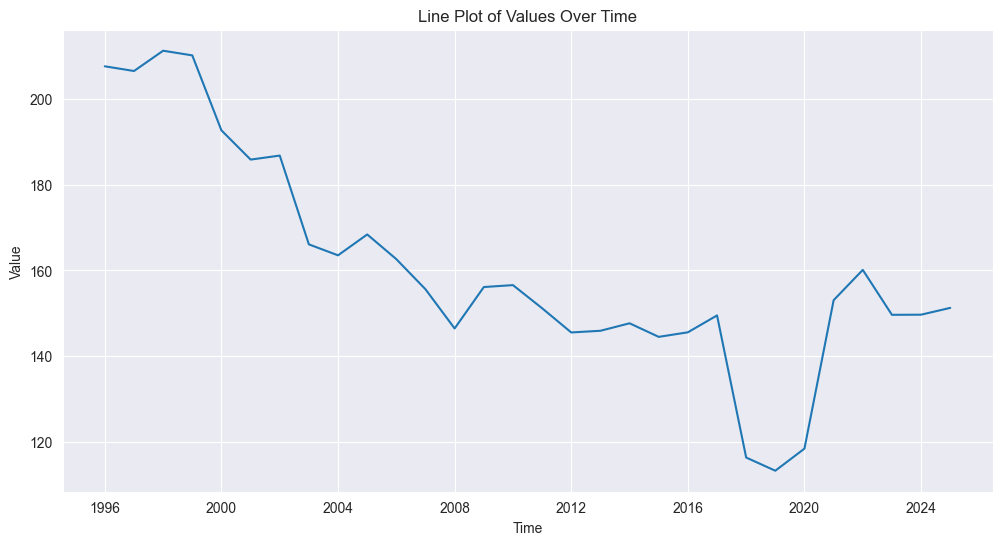

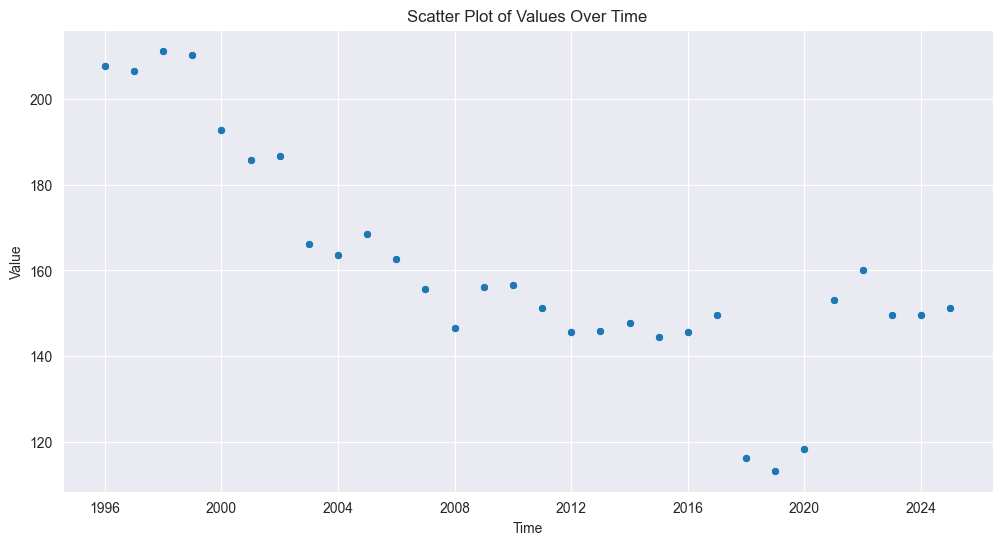

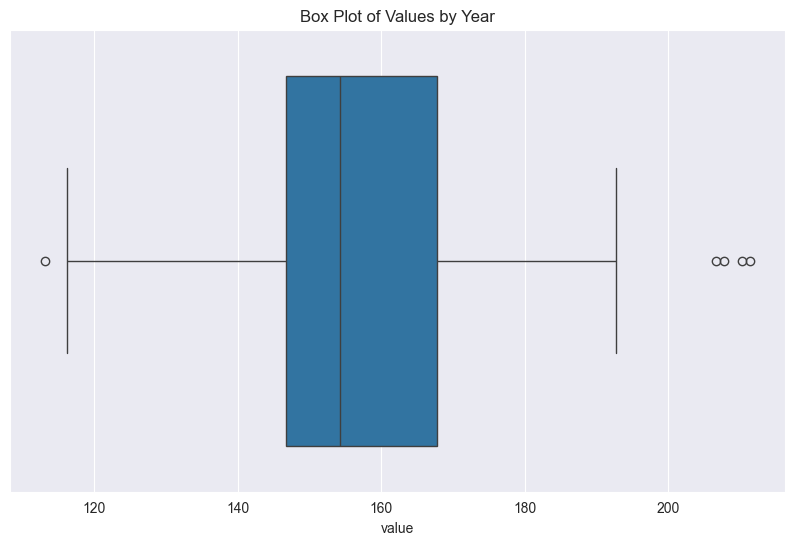

In [92]:
prc_hicp_inw = get_dataframe("prc_hicp_inw")
prc_hicp_inw = fix_dates(prc_hicp_inw)
prc_hicp_inw = remove_empty_columns(prc_hicp_inw)
prc_hicp_inw = melt_dataframe(prc_hicp_inw)
prc_hicp_inw = drop_columns(prc_hicp_inw, ["freq"])
prc_hicp_inw = filter_dataframe(prc_hicp_inw, {"coicop": ["CP01"]})
prc_hicp_inw.name = "prc_hicp_inw"

display(prc_hicp_inw.head())
make_histogram(prc_hicp_inw).show()
make_line_plot(prc_hicp_inw).show()
make_scatter_plot(prc_hicp_inw).show()
make_box_plot(prc_hicp_inw).show()


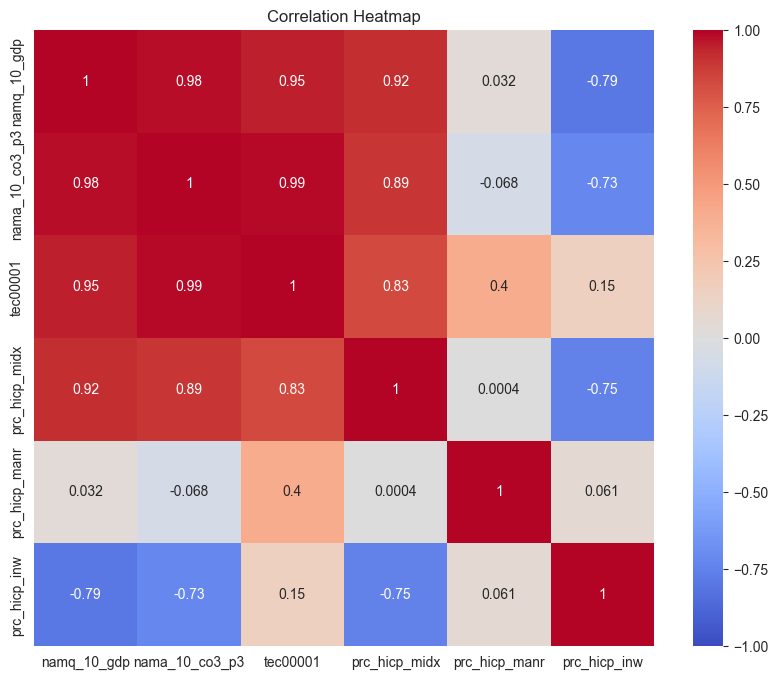

In [93]:
make_correlation_heatmap([
    namq_10_gdp,
    nama_10_co3_p3,
    tec00001,
    prc_hicp_midx,
    prc_hicp_manr,
    prc_hicp_inw
]).show()